In [47]:
import os
import keras
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sys
import pickle
from keras.utils import plot_model
from keras.applications.xception import Xception
from keras.utils import load_img
from keras.utils import img_to_array
from keras.applications.xception import preprocess_input
from keras.models import Model
import string
import numpy as np
from pickle import load
from keras.utils import pad_sequences, to_categorical, plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM ,GRU
from keras.layers import Embedding
from keras.layers import Dropout, Reshape, Lambda, Concatenate
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from nltk.translate.bleu_score import corpus_bleu

emb_dim = 50
snaphot_folder = "D:/Yugant Basnet/FYP Datasets/Model Dmp/"
batch_size = 32

In [48]:
def progressBar(value, endvalue, bar_length=20,job='Job'):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [49]:
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return list(set(dataset))

def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

In [50]:
doc = load_doc("D:/Yugant Basnet/FYP Datasets/Flickr8K_Text/Flickr8k.token.txt")

In [51]:
descriptions = {}
for line in doc.split('\n'):
    try:
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        if image_id not in descriptions:
            descriptions[image_id] = list()
        descriptions[image_id].append(image_desc)
    except :
        print(line)

1000268201_693b08cb0e ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


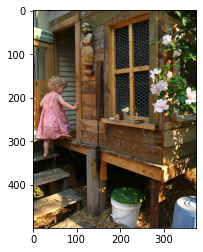

In [52]:
print(next(iter(descriptions)),descriptions[next(iter(descriptions))])

x = plt.imread('D:/Yugant Basnet/FYP Datasets/Flicker8k_Dataset/'+next(iter(descriptions))+'.jpg')
plt.imshow(x)
plt.show()

***Let's Clean the Data***

In [53]:
def clean_data(pairs):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>0]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)
            
    return descriptions

In [54]:
descriptions_clean = clean_data(descriptions)
descriptions[next(iter(descriptions_clean))]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

***Adding start and end token to the sequence of words***

In [55]:
start_token = '<startseq>'
end_token = '<endseq>'
def add_end_start_tokens(descriptions):
    for key in descriptions:
        for i in range(len(descriptions[key])):
            descriptions[key][i] = start_token + ' ' + descriptions[key][i] + ' ' + end_token
    return descriptions

In [56]:
descriptions_tokenSE = add_end_start_tokens(descriptions_clean)
descriptions_tokenSE[next(iter(descriptions_tokenSE))]

['<startseq> a child in a pink dress is climbing up a set of stairs in an entry way <endseq>',
 '<startseq> a girl going into a wooden building <endseq>',
 '<startseq> a little girl climbing into a wooden playhouse <endseq>',
 '<startseq> a little girl climbing the stairs to her playhouse <endseq>',
 '<startseq> a little girl in a pink dress going into a wooden cabin <endseq>']

***Loading train captions***

In [57]:
def load_train_test(descriptions, dataset):
    dataset_ = {}
    for image_id in dataset:
        dataset_[image_id] = descriptions[image_id]
        
    return dataset_

In [58]:
train_imgs_addr = 'D:/Yugant Basnet/FYP Datasets/Flickr8K_Text/Flickr_8k.trainImages.txt'
test_imgs_addr = 'D:/Yugant Basnet/FYP Datasets/Flickr8K_Text/Flickr_8k.testImages.txt'
dev_imgs_addr = 'D:/Yugant Basnet/FYP Datasets/Flickr8K_Text/Flickr_8k.devImages.txt'

train_imgs_names = load_set(train_imgs_addr)
test_imgs_names = load_set(test_imgs_addr)
dev_imgs_names = load_set(dev_imgs_addr)

len(train_imgs_names), len(test_imgs_names), len(dev_imgs_names)

(6000, 1000, 1000)

In [59]:
train_descriptions = load_train_test(descriptions_tokenSE, train_imgs_names)
dev_descriptions = load_train_test(descriptions_tokenSE, dev_imgs_names)
test_descriptions = load_train_test(descriptions_tokenSE, test_imgs_names)

***Reoccuring Vocabulary***

In [60]:
# making a vocabulary of the words that occur more than word_count_threshold time
def create_reoccurring_vocab(descriptions, word_count_threshold = 10):
    # Create a list of all the captions
    all_captions = []
    for key, val in descriptions.items():
        for cap in val:
            all_captions.append(cap)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

    return vocab

In [61]:
vocab = create_reoccurring_vocab(train_descriptions, word_count_threshold = 5)
sorted(vocab)[:10]

['<endseq>',
 '<startseq>',
 'a',
 'about',
 'above',
 'accordion',
 'acrobatic',
 'across',
 'act',
 'action']

In [62]:
oov_token = '<UNK>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' # making sure all the last non digit non alphabet chars are removed
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
tokenizer.fit_on_texts(vocab)
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size :', vocab_size)

vocab_size : 2535


In [63]:
ixtoword = {} # index to word dic
wordtoix = {} # word to index dic

tokenizer.word_index['<PAD0>'] = 0 # no word in vocab has index 0. but padding is indicated with 0
wordtoix = tokenizer.word_index # word to index dic

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

***finding suitable length for sequences to use in training***

In [64]:
# finding the maximum length of questions and answers
# because there are senteces with unusually long lengths, 
# we caculate the max length that p% of data can be placed in
def max_length(desc,p):
    all_desc = []
    # Create a list of all the captions
    for i in desc:
        for j in desc[i]:
            all_desc.append(j)

    length_all_desc = list(len(d.split()) for d in all_desc)

    print('percentile {} of len of questions: {}'.format(p,np.percentile(length_all_desc, p)))
    print('longest sentence: ', max(length_all_desc))

    return int(np.percentile(length_all_desc, p))

max_length = max_length(train_descriptions,90)

print('max-len answer for training: ', max_length)

percentile 90 of len of questions: 18.0
longest sentence:  37
max-len answer for training:  18


In [65]:
# only keep the decriptions that have the words from our vocab
def trimRareWords(desc):
    num_des = 0
    num_trim = 0
    desc_result = desc.copy()
    for d in desc_result:
        desc_result[d]=[]
        
    # Filter out pairs with trimmed words
    i=0
    for d in desc:
        i+=1
        progressBar(value=i, endvalue=len(desc))
        for p in desc[d]:
            num_des += 1
            keep_input = True
            # Check input sentence
            for word in p.split(' '):
                if word not in vocab:
                    keep_input = False
                    break

            # Only keep descriptions that do not contain trimmed word(s) in them
            if keep_input:
                num_trim += 1
                desc_result[d].append(p)

    print("\nTrimmed from {} pairs to {}".format(num_des, num_trim))
    return desc_result

***feature extractor model Xception***

In [66]:
xception = Xception()
extractor = Model(inputs=xception.inputs, outputs=xception.layers[-2].output) # removing 2 last fully connected layers 
print(extractor.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

In [67]:
def extract_features(description, model, inpute_size = (299,299)):
    directory = 'D:/Yugant Basnet/FYP Datasets/Flicker8k_Dataset/'
    features = {}
    i = 0
    for name in description:
        progressBar(value=i,endvalue=len(descriptions))
        i +=1
        filename =os.path.join(directory, name+'.jpg')
        image = load_img(filename, target_size=inpute_size)
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature.reshape(2048)
    return features

In [22]:
train_features = extract_features(train_descriptions, extractor)
test_features = extract_features(test_descriptions, extractor)
dev_features = extract_features(dev_descriptions, extractor)

pickle.dump(train_features, open('D:/Yugant Basnet/FYP Datasets/PKL Dmp/train_features.pkl', 'wb'))
pickle.dump(test_features, open('D:/Yugant Basnet/FYP Datasets/PKL Dmp/test_features.pkl', 'wb'))
pickle.dump(dev_features, open('D:/Yugant Basnet/FYP Datasets/PKL Dmp/dev_features.pkl', 'wb'))

Job Completion: [->                  ] 12%

In [68]:
with open('D:/Yugant Basnet/FYP Datasets/PKL Dmp/dev_features.pkl','rb') as f:
    dev_features= pickle.load(f)    
with open('D:/Yugant Basnet/FYP Datasets/PKL Dmp/train_features.pkl','rb') as f:
    train_features= pickle.load(f)
with open('D:/Yugant Basnet/FYP Datasets/PKL Dmp/test_features.pkl','rb') as f:
    test_features= pickle.load(f)

***Data Genarator***

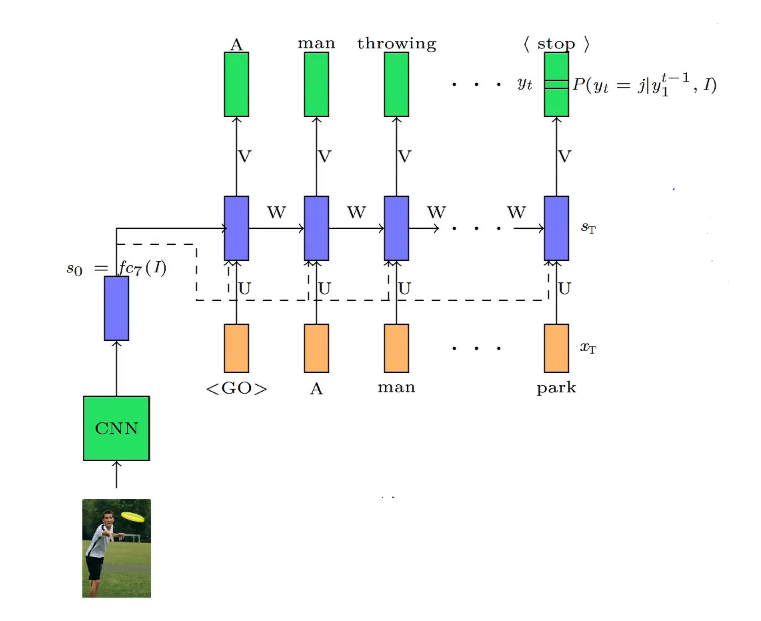

In [69]:
# outputs a batch of captions-pictures
def data_generator(descriptions, photos):
    X1, X2, y = [], [], []
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # find the index of each word of the caption in vocabulary
                seq = tokenizer.texts_to_sequences(desc.split())
                # split one sequence into multiple X, y pairs
                # Each step of the following for loop selects one word
                # from the caption, consider that word as y and
                # all the words before that will be the X
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i] # words until i are inseq word i is outseq
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n == batch_size:
                yield [[np.array(X1), np.array(X2).squeeze(axis=-1)], np.array(y).squeeze(axis=-1)]
                X1, X2, y = list(), list(), list()
                n=0

In [70]:
d = next(data_generator(dev_descriptions, dev_features))
d[0][0].shape, d[0][1].shape, d[1].shape

((2027, 2048), (2027, 18), (2027,))

***Word Emeddings glove***

In [71]:
def make_embedding_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # just a zero matrix 
    else:
        glove_dir = 'D:/Yugant Basnet/FYP Datasets/Glove/'
        embeddings_index = {} 
        f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        # Get x-dim dense vector for each of the vocab_rocc
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
        print('GloVe loaded!')
        
    embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

In [72]:
# in order to make model faster, I load embd outside the make_model
embedding_layer = make_embedding_layer(emb_dim, glove=True)

GloVe loaded!


***LOSS***

In [73]:
# for masking pad0 outputs
def masked_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False) # sparse cat gets pred classes in 'int' form
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

***Constructing the model***

In [74]:
from keras.layers import RepeatVector
def make_model(embedding ,dout= 0.2, feature_size= 2048, units= 256):
    
    features = Input(shape=(feature_size,)) # output size of feature extractor
    X_fe_one_dim = Dense(units, activation='relu')(features) # because i have used bidirectional LSTM, the number of units should
                                                   # become double here in order for the add function to work
    X_fe = RepeatVector(max_length)(X_fe_one_dim)
    X_fe = Dropout(dout)(X_fe)
    
    seq = Input(shape=(max_length,))
    X_seq = embedding(seq)
    X_seq = Lambda(lambda x: x, output_shape=lambda s:s)(X_seq) # remove mask from the embedding cause concat doesn't support it
    X_seq = Dropout(dout)(X_seq)
    X_seq = Concatenate(name='concat_features_word_embeddings', axis=-1)([X_fe,X_seq])
    X_seq = GRU(units, return_sequences=True)(X_seq,initial_state=X_fe_one_dim) # passing features as init_state
    X_seq = Dropout(dout + 0.2)(X_seq)
    X_seq = GRU(units, return_sequences=False)(X_seq)

    outputs = Dense(vocab_size, activation='softmax')(X_seq)

    # merge the two input models
    model = Model(inputs=[features, seq], outputs = outputs, name='model_with_features_each_step')
    return model

***compiling the model***

In [75]:
model = make_model(embedding_layer)
model.summary()

Model: "model_with_features_each_step"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 256)          524544      ['input_5[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 18, 50)       126750      ['input_6[0][0]']                
                                                                      

In [76]:
model.compile(loss=masked_loss_function, optimizer= 'adam')

***Training the model***

In [77]:
history={'loss':[], 'BLEU_val':[]}

In [78]:
# generate a description for an image greedy way
def generate_desc(model, photo_fe, inference= False):
    # seed the generation process
    in_text = start_token
    # iterate over the whole length of the sequence
    # generate one word at each iteratoin of the loop
    # appends the new word to a list and makes the whole sentence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences(in_text.split()) #[wordtoix[w] for w in in_text.split() if w in wordtoix]
        # pad input
        photo_fe = photo_fe.reshape((1,2048))
        sequence = pad_sequences([sequence], maxlen=max_length).reshape((1,max_length))
        # predict next word
        yhat = model.predict([photo_fe,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = ixtoword[yhat]
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next v
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == end_token:
            break
            
    if inference == True:
        in_text = in_text.split()
        if len(in_text) == max_length:
            in_text = in_text[1:] # if it is already at max len and endseq hasn't appeared
        else:
            in_text = in_text[1:-1]
        in_text = ' '.join(in_text)
        
    return in_text

In [79]:
def beam_search_pred(model, pic_fe, wordtoix, K_beams = 3, log = False):
    start = [wordtoix[start_token]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length)) #sequence of most probable words 
                                                                                         # based on the previous steps
            preds = model.predict([pic_fe.reshape(1,2048), sequence])
            word_preds = np.argsort(preds[0])[-K_beams:] # sort predictions based on the probability, then take the last
                                                         # K_beams items. words with the most probs
            # Getting the top <K_beams>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words4
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != end_token:
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [80]:
# calculating BLEU score of predictions
def evaluate_model(model, descriptions, photos_fe, K_beams= 3, log=False):
    actual, predicted = list(), list()
    # step over the whole set
    i=0
    for key, desc_list in descriptions.items():
        # generate description
        i+=1
        progressBar(i, len(descriptions), bar_length=20,job='Evaluating')
        if K_beams == 1:
            yhat = generate_desc(model, photos_fe[key])
        else:
            yhat=beam_search_pred(model, photos_fe[key], wordtoix, K_beams = K_beams,log=log)
        
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
    # calculate BLEU score
    b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\n')
    print('BLEU-1: %f' % b1)
    print('BLEU-2: %f' % b2)
    print('BLEU-3: %f' % b3)
    print('BLEU-4: %f' % b4)
    return [b1,b2,b3,b4]

In [81]:
from keras.callbacks import ReduceLROnPlateau
Reduce_lr= ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)

====


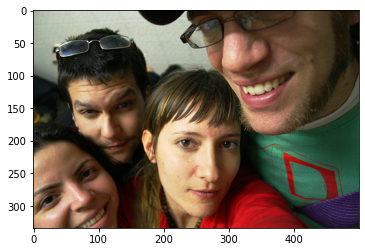

Greedy: embrace embrace embrace among gathering tripod bouncy hugging opens hugging opens opens bags pets rally tripod africanamerican


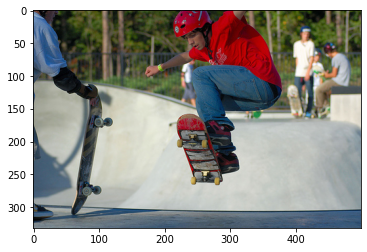

Greedy: swing swing marketplace marketplace volleyball volleyball hotel hotel tree tree volleyball volleyball hotel hotel tree tree volleyball


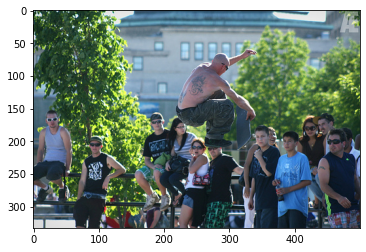

Greedy: chess sheep pretending pretending muzzle muzzle muzzle muzzle crouching bouncy crouching french french muzzle muzzle muzzle crouching


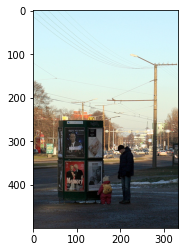

Greedy: toward soldier branches jeans fetches fetches opens lays lays lays jersey incoming gathering gathering gathering gathering gathering
====


In [82]:
def test(i=np.random.randint(len(test_features)), j=np.random.randint(len(test_features)),
         k=np.random.randint(len(test_features)), q=np.random.randint(len(test_features)), show_pic=False):
    print('====')
    pic = list(test_features.keys())[i]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('D:/Yugant Basnet/FYP Datasets/Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))
    
    pic = list(test_features.keys())[j]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('D:/Yugant Basnet/FYP Datasets/Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))
    
    pic = list(test_features.keys())[k]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('D:/Yugant Basnet/FYP Datasets/Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:", generate_desc(model, fe, inference=True))
    pic = list(test_features.keys())[q]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('D:/Yugant Basnet/FYP Datasets/Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))

    print('====')
    
    
test(show_pic=True)    

In [83]:
steps = len(train_descriptions)//batch_size

In [84]:
# create the data generator
generator = data_generator(train_descriptions, train_features)

In [40]:
ep=1

In [41]:
for i in range(ep, 100):
    
    print('Epoch :',i,'\n')
    # fit for one epoch
    h = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )
    ep = i + 1
    history['loss'].append(h.history['loss'])
    
    # save model every 3 epochs
    if i % 3 == 0:
        test() 
        model.save_weights(snaphot_folder+'/model_' + str(i) + '.h5')
        belus= evaluate_model(model, dev_descriptions, dev_features, K_beams=1)    
        history['BLEU_val'].append((belus,i))

    print('\n','='*80)

Epoch : 1 



C:\Users\Admin\AppData\Local\Temp\ipykernel_1852\3000083733.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )


187/187 [==============================] - 451s 2s/step - loss: 5.0561 - lr: 0.0010

Epoch : 2 

187/187 [==============================] - 447s 2s/step - loss: 4.6145 - lr: 0.0010

Epoch : 3 

187/187 [==============================] - 447s 2s/step - loss: 4.1131 - lr: 0.0010
====
Greedy: a man in a red shirt is in a <UNK>
Greedy: a man in a red shirt is running a ball
Greedy: a dog is running in the snow
Greedy: a boy is in a blue shirt is in a <UNK>
====
Evaluating Completion: [------------------->] 100%

BLEU-1: 0.591577
BLEU-2: 0.366139
BLEU-3: 0.248350
BLEU-4: 0.126547

Epoch : 4 

187/187 [==============================] - 241s 1s/step - loss: 3.7157 - lr: 0.0010

Epoch : 5 

187/187 [==============================] - 243s 1s/step - loss: 3.4402 - lr: 0.0010

Epoch : 6 

187/187 [==============================] - 243s 1s/step - loss: 3.2507 - lr: 0.0010
====
Greedy: a boy in a red shirt is walking on a sidewalk
Greedy: a man in a red shirt is playing a basketball game
Greedy: a 

KeyboardInterrupt: 

In [85]:
# apprently model overfits badly after epoch 100. so im just gonna use the model from 60th epoch
i=39
model.load_weights(snaphot_folder+'/model_' + str(i) + '.h5')

***Test the model***

In [43]:
evaluate_model(model=model,descriptions=test_descriptions,photos_fe=test_features,K_beams=1)

Evaluating Completion: [->                  ] 8%

KeyboardInterrupt: 

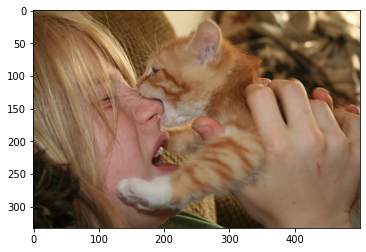

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step
Greedy: a ready mountain her green with a to
Beam K= 3: a ready on ready mountain her mouth with a to the newspaper holds brick
Beam K= 5: a ready on ready mountain her mouth with a to the newspaper holds brick
Beam log K= 3: a ready on ready mountain her mouth with a to the newspaper holds brick
Beam log K= 5: a ready on ready mountain her mouth with a to the newspaper holds brick


In [86]:
pic = list(test_features.keys())[111]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('D:/Yugant Basnet/FYP Datasets/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
beam_3 = beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False)
beam_5 = beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False)
beam_log_3 = beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True)
beam_log_5 = beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True)
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:", beam_3)
print("Beam K= 5:", beam_5)
print("Beam log K= 3:", beam_log_3)
print("Beam log K= 5:", beam_log_5)